In [1]:
from subpred.protein_go_datasets import get_transmembrane_transporter_dataset, get_stats

Stats on all proteins

In [2]:
dataset_athaliana = get_transmembrane_transporter_dataset(  # athaliana
    organism_ids=[3702],
    swissprot_only=False,
    datasets_path="../data/datasets/",
    exclude_iea_go_terms=False,
    max_sequence_evidence_code=2,
    remove_proteins_without_gene_names=False,
)
get_stats(*dataset_athaliana)

cd-hit: clustered 1773 sequences into 646 clusters at threshold 50
cd-hit: clustered 1773 sequences into 923 clusters at threshold 70
cd-hit: clustered 1773 sequences into 1203 clusters at threshold 90
cd-hit: clustered 1773 sequences into 1554 clusters at threshold 100


n_transporters  \
swissprot_reviewed has_gene_name go_evidence   protein_existence_evidence clustering                   
False              False         computational protein_level              100                      3   
                                                                          None                     3   
                                               transcript_level           50                       3   
                                                                          70                       4   
                                                                          90                       7   
                                                                          100                     37   
                                                                          None                    49   
                   True          computational protein_level              50                      87   
                                                                          70                     114   
                                                                          90                     153   
                                                                          100                    329   
                                                                          None                   433   
                                               transcript_level           50                       7   
                                                                          70                      13   
                                                                          90                      19   
                                                                          100                     84   
                                                                          None                   164   
                                 experiment    protein_level              50                      25   
                                                                          70                      33   
                                                                          90                      38   
                                                                          100                     41   
                                                                          None                    42   
                                               transcript_level           50                       3   
                                                                          70                       5   
                                                                          90                       5   
                                                                          100                      6   
                                                                          None                     6   
True               True          computational protein_level              50                     206   
                                                                          70                     287   
                                                                          90                     370   
                                                                          100                    408   
                                                                          None                   418   
                                               transcript_level           50                     208   
                                                                          70                     338   
                                                                          90                     462   
                                                                          100                    492   
                                                                          None                   504   
                              

Subset

In [3]:
dataset_athaliana = (
    get_transmembrane_transporter_dataset(  # athaliana
        organism_ids=[3702],
        swissprot_only=True,
        datasets_path="../data/datasets/",
        exclude_iea_go_terms=True,
        max_sequence_evidence_code=1,
        remove_proteins_without_gene_names=True,
    )
)
get_stats(*dataset_athaliana)

cd-hit: clustered 420 sequences into 276 clusters at threshold 50
cd-hit: clustered 420 sequences into 344 clusters at threshold 70
cd-hit: clustered 420 sequences into 403 clusters at threshold 90
cd-hit: clustered 420 sequences into 419 clusters at threshold 100


n_transporters  \
swissprot_reviewed has_gene_name go_evidence protein_existence_evidence clustering                   
True               True          experiment  protein_level              50                     276   
                                                                        70                     344   
                                                                        90                     403   
                                                                        100                    419   
                                                                        None                   420   

                                                                                    n_terms  
swissprot_reviewed has_gene_name go_evidence protein_existence_evidence clustering           
True               True          experiment  protein_level              50              264  
                                                                        70              281  
                                                                        90              288  
                                                                        100             288  
                                                                        None            288

Sugar/Amino subset

In [4]:
df_sequences_athaliana, df_goa_athaliana = dataset_athaliana
df_goa_athaliana = (
    df_goa_athaliana[
        df_goa_athaliana.go_term_ancestor.isin(
            [
                "sugar transmembrane transporter activity",
                "amino acid transmembrane transporter activity",
            ]
        )
    ][["Uniprot", "go_term_ancestor"]]
    .drop_duplicates()
    .reset_index(drop=True)
)  # .go_term_ancestor.value_counts()
df_sequences_athaliana = df_sequences_athaliana[
    df_sequences_athaliana.index.isin(df_goa_athaliana.Uniprot)
]


df_goa_athaliana.go_term_ancestor.value_counts()

# clustering before or after?

# TCDB identifiers

go_term_ancestor
amino acid transmembrane transporter activity    33
sugar transmembrane transporter activity         32
Name: count, dtype: int64

In [5]:
from subpred.cdhit import cd_hit

cluster_representatives_70 = set(cd_hit(
    df_sequences_athaliana.sequence, identity_threshold=70
))
df_sequences_athaliana = df_sequences_athaliana[df_sequences_athaliana.index.isin(cluster_representatives_70)]
df_goa_athaliana = df_goa_athaliana[df_goa_athaliana.Uniprot.isin(cluster_representatives_70)]
df_goa_athaliana.go_term_ancestor.value_counts()

cd-hit: clustered 65 sequences into 54 clusters at threshold 70


go_term_ancestor
sugar transmembrane transporter activity         28
amino acid transmembrane transporter activity    26
Name: count, dtype: int64

In [6]:
dataset_athaliana = (df_sequences_athaliana, df_goa_athaliana)

Features

Plots

In [ ]:
from subpred.features import calculate_features
from subpred.compositions import calculate_comp, ALPHABET_3DI
from subpred.structural_sequences import get_3Di_sequences
from subpred.embeddings import get_nlp_features
from sklearn.preprocessing import scale
import pandas as pd

dataset_sequences, dataset_uniprot = dataset_athaliana
# original sequences features
df_features_std = calculate_features(
    dataset_sequences.sequence, standardize_samples=True
)
# df_features_nonstd = calculate_features(
#     dataset_sequences.sequence, standardize_samples=False
# )


# 3Di sequence features

# TODO turn into method
standardize_samples_3Di = True
sequences_3Di = get_3Di_sequences(dataset_sequences.index)
df_3Di_AAC = calculate_comp(sequences=sequences_3Di, k=1, alphabet=ALPHABET_3DI)
df_3Di_PAAC = calculate_comp(sequences=sequences_3Di, k=2, alphabet=ALPHABET_3DI)
df_3Di_KMER3 = calculate_comp(sequences=sequences_3Di, k=3, alphabet=ALPHABET_3DI)

features_3Di = [df_3Di_AAC, df_3Di_PAAC, df_3Di_KMER3]
if standardize_samples_3Di:
    features_list = [
        pd.DataFrame(
            data=scale(feature, axis=1),
            index=feature.index,
            columns=feature.columns,
        )
        for feature in features_3Di
    ]
df_features_3Di = pd.concat(
    features_list,
    axis=1,
)

# AA Embeddings
df_embeddings_prott5_AA = get_nlp_features(
    sequences=dataset_sequences.sequence,
    model="protT5",
    sequence_type="AA",
    half_precision=True,
)
df_embeddings_prostt5_AA = get_nlp_features(
    sequences=dataset_sequences.sequence,
    model="prostT5",
    sequence_type="AA",
    half_precision=True,
)
# 3Di Embeddings
df_embeddings_prott5_3Di = get_nlp_features(
    sequences=sequences_3Di,
    model="prostT5",
    sequence_type="3Di",
    half_precision=True,
)

import numpy as np

np.random.seed(0)
df_dummy_feature = pd.DataFrame(
    np.random.rand(54, 1024),
    index=df_embeddings_prott5_AA.index,
    columns=[f"dummy{i}" for i in range(1024)],
)

2025-05-21 20:10:09.701913: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 20:10:09.711366: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747851009.722036  125606 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747851009.724822  125606 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-21 20:10:09.733115: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [12]:
# TODO check for outliers with one-class svm, and z-score. tell which distribution?
df_embeddings_prott5_AA

/home/andy/miniforge3/envs/subpred_deeplearning/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()
/home/andy/miniforge3/envs/subpred_deeplearning/lib/python3.12/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,protT5_AA_fp16_0,protT5_AA_fp16_1,protT5_AA_fp16_2,protT5_AA_fp16_3,protT5_AA_fp16_4,protT5_AA_fp16_5,protT5_AA_fp16_6,protT5_AA_fp16_7,protT5_AA_fp16_8,protT5_AA_fp16_9,...,protT5_AA_fp16_1014,protT5_AA_fp16_1015,protT5_AA_fp16_1016,protT5_AA_fp16_1017,protT5_AA_fp16_1018,protT5_AA_fp16_1019,protT5_AA_fp16_1020,protT5_AA_fp16_1021,protT5_AA_fp16_1022,protT5_AA_fp16_1023
Uniprot,,,,,,,,,,,,,,,,,,,,,
Q84WN3,0.033875,0.081726,0.025070,-0.031525,0.017792,0.017792,0.008095,-0.051605,0.012947,-0.029373,...,-0.042206,0.015617,-0.011940,-0.034546,0.031555,-0.053955,0.017914,-0.010849,0.026627,0.015549
Q8GUM3,0.041565,0.111816,0.030441,0.010803,-0.008858,0.038849,0.010399,-0.058777,0.015373,-0.035980,...,-0.032104,-0.030701,0.039337,-0.015305,0.034607,-0.040588,-0.013359,0.023178,0.005527,0.000133
Q8L9J7,0.043854,0.101013,0.051178,-0.027435,0.022659,0.027161,-0.008385,-0.063599,0.017792,-0.044006,...,-0.033661,-0.018341,0.006805,-0.042206,0.042114,-0.049530,-0.007706,-0.006126,0.027023,0.018433
Q8VZ80,0.038513,0.075317,0.019806,0.010857,0.007042,0.038879,-0.001412,-0.034302,0.014526,-0.063782,...,-0.010735,-0.037231,0.005016,-0.032196,0.029938,-0.038177,-0.004700,0.016129,-0.003929,-0.016495
Q9FMF7,0.043518,0.115601,0.012268,0.030487,-0.004139,0.045532,-0.028687,-0.057831,0.043365,0.017944,...,-0.060425,0.016022,0.031342,-0.039307,0.029251,-0.004738,-0.042664,0.021790,0.027313,-0.001698
Q9SMM5,0.031830,0.090271,0.033539,-0.024902,-0.001379,0.024612,0.011398,-0.072632,0.017365,-0.041229,...,-0.049622,-0.001115,0.019791,-0.026489,0.022263,-0.040680,-0.002941,0.003689,0.021439,0.026703
Q94KE0,0.014915,0.048981,0.014786,-0.006115,-0.022110,0.051727,0.004391,-0.022110,0.008049,-0.042145,...,-0.011322,-0.033661,-0.017166,-0.055450,0.038574,-0.019638,-0.003244,-0.028900,0.042389,-0.005020
Q9C8E7,0.034027,0.067993,0.033539,0.014587,0.001639,0.033295,-0.017990,-0.071228,0.051941,-0.035736,...,-0.014664,-0.004017,0.008942,0.005413,0.041199,-0.019638,-0.009270,0.025955,0.024429,-0.003727
Q9FG00,0.027985,0.083313,0.044556,0.002428,-0.000306,0.032623,-0.036041,-0.016006,0.020523,-0.057922,...,-0.061981,-0.049622,-0.018082,-0.014511,0.001032,-0.009499,-0.001515,-0.006752,0.010643,-0.014290


In [9]:
from sklearn.preprocessing import LabelEncoder

def get_ml_dataset(df_features, df_goa):
    sample_names = df_features.index.to_numpy()
    feature_names = df_features.columns.to_numpy()
    series_labels = df_goa[df_goa.Uniprot.isin(sample_names)].set_index("Uniprot")

    assert not series_labels.index.duplicated().any()

    label_encoder = LabelEncoder()

    X = df_features.loc[sample_names].to_numpy()
    y_str = series_labels.loc[sample_names].to_numpy().ravel()
    y = label_encoder.fit_transform(y_str)

    return X,y,sample_names,feature_names

In [ ]:
# X,y,sample_names,feature_names = get_ml_dataset(df_features_std)
X,y,sample_names,feature_names = get_ml_dataset(df_dummy_feature, df_goa_athaliana)

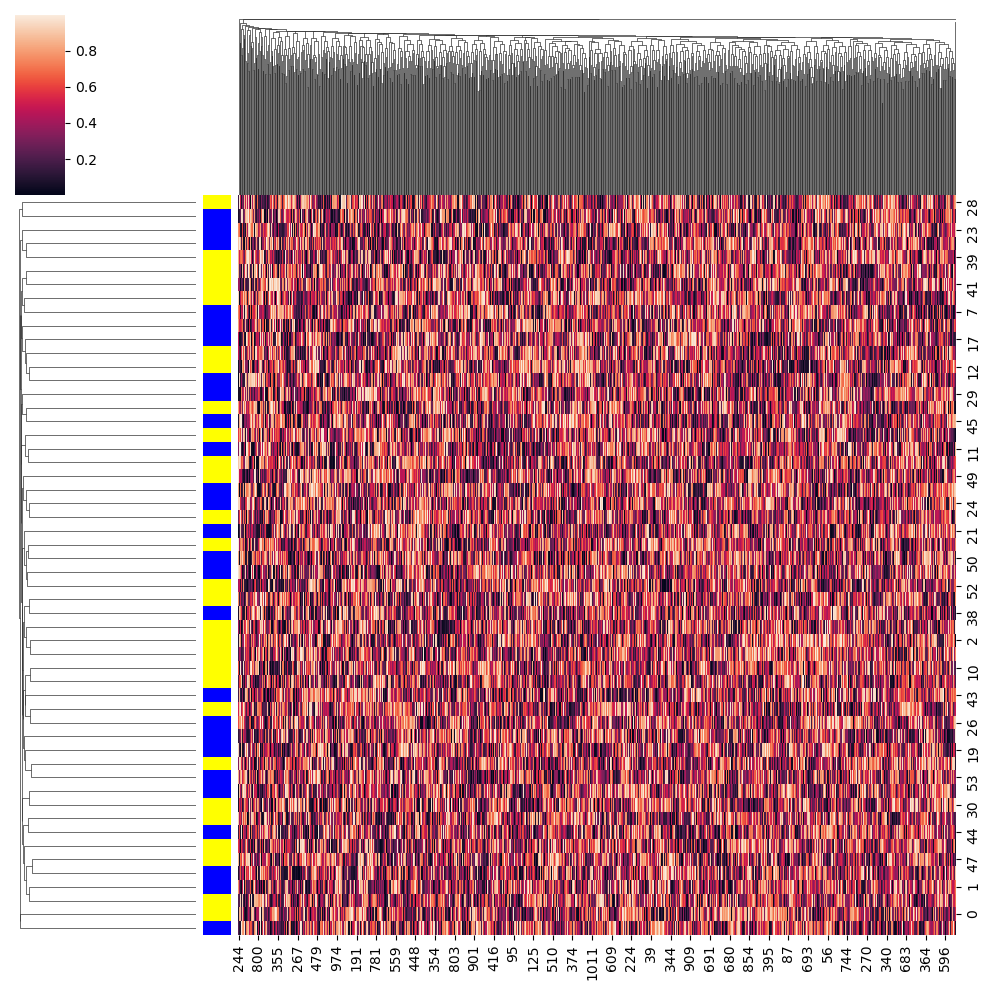

In [15]:
import seaborn as sns

sns.clustermap(X, row_colors=["yellow" if label == 1 else "blue" for label in y])

SVM model

In [16]:
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, LeaveOneOut
from sklearn.metrics import f1_score, balanced_accuracy_score

model = make_pipeline(VarianceThreshold(),StandardScaler(), SelectKBest(), SVC())

max_features = int(len(feature_names)/2)

param_grid = {
    "selectkbest__k": list(range(1,max_features,1)),
    "svc__class_weight" : ["balanced"]
    # "svc__C":[0.1, 1, 10],
    # "svc__gamma": ["scale", "auto", 0.1, 1, 10]
}

gridsearch = GridSearchCV(estimator=model, param_grid=param_grid, scoring="balanced_accuracy", cv=StratifiedKFold(3), n_jobs=-1)

gridsearch_results = gridsearch.fit(X,y)
print(gridsearch_results.best_score_)
print(gridsearch_results.best_params_)
df_results = pd.DataFrame(gridsearch_results.cv_results_)
display(df_results.filter(like="test_score", axis=1).sort_values("rank_test_score"))

0.799537037037037
{'selectkbest__k': 1, 'svc__class_weight': 'balanced'}


,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.7875,0.777778,0.833333,0.799537,0.024225,1
6,0.7875,0.666667,0.611111,0.688426,0.073636,2
1,0.5875,0.555556,0.777778,0.640278,0.098098,3
5,0.7875,0.444444,0.611111,0.614352,0.140071,4
14,0.5500,0.500000,0.777778,0.609259,0.120896,5
...,...,...,...,...,...,...
51,0.4500,0.388889,0.444444,0.427778,0.027592,507
290,0.4875,0.388889,0.388889,0.421759,0.046486,508
291,0.4875,0.388889,0.388889,0.421759,0.046486,508
285,0.4875,0.388889,0.388889,0.421759,0.046486,508


In [17]:
cross_val_score(gridsearch, X, y, cv=StratifiedKFold(3), scoring="balanced_accuracy")#.mean()

array([0.625     , 0.38888889, 0.61111111])

In [ ]:
# TODO linear svm, linear svm with nyström, DNN